<a href="https://colab.research.google.com/github/redboxup/masters_thesis/blob/main/reinforcement_learning/chemotaxis/chemotaxis___final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gym
import numpy as np
import sys
if "../" not in sys.path:
    sys.path.append("../")
from collections import defaultdict

import itertools
import collections
from typing import Any,List,Sequence,Tuple
import tqdm
# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

In [45]:
#@title Environment of Windy grid
import gym
import numpy as np
import sys
from gym.envs.toy_text import discrete
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
#STAY = 4

def conv2coord(x,y):
  X = 9-x
  Y = 9-y
  return (X,Y) 

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos."""

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

R = np.zeros(100)

class WindyGridworldEnv(discrete.DiscreteEnv):

    metadata = {'render.modes': ['human', 'ansi']}

    def _limit_coordinates(self, coord):
        coord[0] = min(coord[0], self.shape[0] - 1)
        coord[0] = max(coord[0], 0)
        coord[1] = min(coord[1], self.shape[1] - 1)
        coord[1] = max(coord[1], 0)
        return coord

    def _calculate_transition_prob(self, current, delta, winds,C):
        new_position = np.array(current) + np.array(delta) + np.array([-1, 0]) * winds[tuple(current)]
        new_position = self._limit_coordinates(new_position).astype(int)
        new_state = np.ravel_multi_index(tuple(new_position), self.shape)
        current_ = conv2coord(current[0],current[1])
        reward =  -1 + C[tuple(current_)]

        return [(1.0, new_state, reward, False)],reward

    def __init__(self):
        self.shape = (10, 10)

        nS = np.prod(self.shape)
        nA = 4

        # Wind strength is zero
        winds = np.zeros(self.shape)
        winds[:,[3,4,5,8]] = 0
        winds[:,[6,7]] = 0

        #Concentration field
        # Our 2-dimensional distribution will be over variables X and Y
        N = 10
        X = np.linspace(9, 0, N)
        Y = np.linspace(0, 9, N)
        X, Y = np.meshgrid(X, Y)

        # Mean vector and covariance matrix
        mu = np.array([7,2])
        Sigma = np.array([[ 5 , 0], [0,  5]])

        # Pack X and Y into a single 3-dimensional array
        pos = np.empty(X.shape + (2,))
        pos[:, :, 0] = X
        pos[:, :, 1] = Y


        # The distribution on the variables X, Y packed into pos.
        C = multivariate_gaussian(pos, mu, Sigma)
        C = C*100
        #gradient of the concentration field
        #gradC = np.gradient(C,axis = 0) 

        #C = C #+ gradC

        # Calculate transition probabilities
        P = {}
        xx = 0
        for s in range(nS):
            position = np.unravel_index(s, self.shape)
            P[s] = { a : [] for a in range(nA) }
            P[s][UP],R[s] = self._calculate_transition_prob(position, [-1, 0], winds,C)
            P[s][RIGHT],xx = self._calculate_transition_prob(position, [0, 1], winds,C)
            P[s][DOWN],xx = self._calculate_transition_prob(position, [1, 0], winds,C)
            P[s][LEFT],xx = self._calculate_transition_prob(position, [0, -1], winds,C)
            #P[s][STAY],xx = self._calculate_transition_prob(position,[0,0],winds,C)

        # We always start in state (3, 0)
        isd = np.zeros(nS)
        isd[np.ravel_multi_index((3,0), self.shape)] = 1.0

        super(WindyGridworldEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode='human', close=False):
        self._render(mode, close)

    def _render(self, mode='human', close=False):
        if close:
            return

        outfile = StringIO() if mode == 'ansi' else sys.stdout

        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            # print(self.s)
            if self.s == s:
                output = " x "
            elif position == (7,7):
                output = " S "
            else:
                output = " o "

            if position[1] == 0:
                output = output.lstrip()
            if position[1] == self.shape[1] - 1:
                output = output.rstrip()
                output += "\n"

            outfile.write(output)
        outfile.write("\n")

In [3]:
env = WindyGridworldEnv()

In [4]:
print(env.reset())

30


In [5]:
# Up:0; Right:1; Down:2; Left:3; Stay:4;
env.render()

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  S  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o



In [6]:
env.step(1)

(31, -0.9952144044159906, False, {'prob': 1.0})

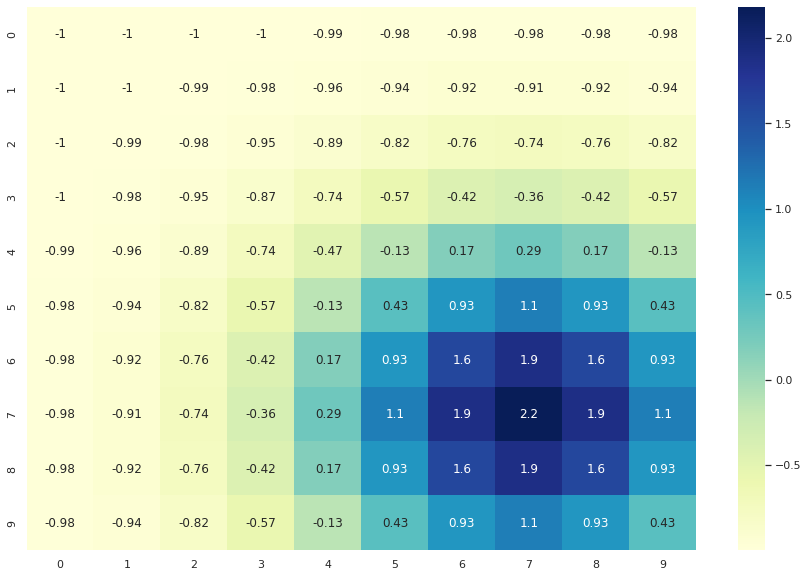

In [7]:
#concentration field
R_ = np.reshape(R,[10,10])
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(R_, annot=True,cmap = "YlGnBu")

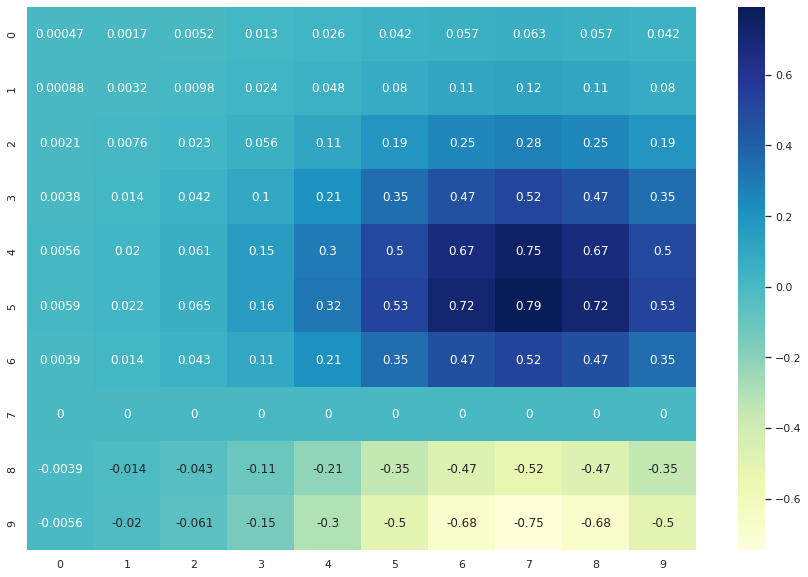

In [8]:
#gradient of concentration field
gradR = np.gradient(R_+1,axis = 0)
sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(gradR, annot=True,cmap = "YlGnBu")

In [9]:
#policy neural network
#let us initialise parameters in a q matrix of size N_a x N_s
q = np.ones([4,100])
#let us define a function that will return z(s,a) matrices
def z(state,action):
  z_ = np.zeros([100,4])
  z_[state][action] = 1
  return z_

In [10]:
#let us now define the h function
def h(s_i,a_j):
  z_ = z(s_i,a_j)
  h_ = q[a_j][s_i]*z_[s_i][a_j]
  return h_

In [11]:
#now let us define the policy function
def policy(state):
  sum = 0
  p = []
  for j in range(4):
    sum += np.exp(h(state,j))
  #now probability corresponding to the action
  for j in range(4):
    p_ = np.exp(h(state,j))/sum
    p.append(p_)
  return p

In [12]:
#code to sample an action from given probability distribution
def sample_action(state):
  prob_action = policy(state)
  action = np.random.choice(np.arange(4),p = prob_action)
  return action

In [13]:
policy(50)

[0.25, 0.25, 0.25, 0.25]

In [14]:
sample_action(50)

1

In [15]:
#convert state into is feature vector
def y(s):
  s_v = np.zeros(100)
  s_v[s] = 1
  return s_v

In [16]:
#state-value function linear approximation
def v(w,s):
  s_v = y(s)
  return np.dot(w.T,s_v)

#gradient of state-value function
def grad_v(w,s):
  s_v = y(s)
  return s_v

#let us initialise weights of the state-value function
w = np.ones(100)

In [17]:
#let us get some expected value
v(w,50)

1.0

In [18]:
#main part of the code
#initialising step-size vector
alpha = 0.001
alpha_w = alpha*np.ones(np.shape(w))
alpha_q = alpha*np.ones(np.shape(q))

In [19]:
#defining important parameters
gamma = 1

In [20]:
#loop forever(for each episode)
def run_episode(q,w):
  #first state will be
  state = env.reset()
  is_done = False 
  I = 1
  #loop while S is not terminal for each time step
  no_step = 0
  total_reward = 0
  while no_step<= 100:
    #sample an action using the policy
    action = sample_action(state)
    #take the action A, observe S', R
    new_state, reward, is_done, _ = env.step(action)
    delta = reward + gamma*v(w,new_state) -v(w,state)
    #defining some important parameters
    r_exp = reward + v(w,new_state)
    beta = r_exp - v(w,state)
    #now we will update the weight parameters
    #using adam-algorithm we will write the standard stochastic gradient descent as
    z_times_policy = 0
    prob_action = policy(state)
    for i in range(4):
      z_times_policy += prob_action[i]*z(state,i)
    z_ = z(state,action)
    z_times_policy = z_times_policy.transpose()
    z_ = z_.transpose()
    q += alpha*beta*(z_-z_times_policy)
    w += alpha*beta*y(state)
    no_step += 1
    total_reward += reward
    #print(state,action,reward,no_step)
    state = new_state
  return no_step,total_reward

In [21]:
#to run an episode but not update its values
def run_episode_dont_update(q,w):
  state = env.reset()
  is_done = False
  #loop while S is not terminal for each time step
  no_step = 0
  total_reward = 0
  while no_step <= 100:
    action = sample_action(state)
    new_state, reward, is_done, _ = env.step(action)
    no_step += 1
    total_reward += reward
    state = new_state
  return no_step,total_reward

In [22]:
steps,G = run_episode(q,w)
print(steps,G)

101 36.97321472394502


In [23]:
#let us find the mean for the model
steps, G = run_episode_dont_update(q,w)
print(steps,G)

101 -65.70409158589817


In [24]:
#let us create a plot to see how the model behaves over 150 episodes
reward_tot = []
no_episodes = []
tot_episodes = 0
N = 150
for i in range(20):
  rew = 0
  for j in range(N):
    steps,rew_temp = run_episode_dont_update(q,w)
    rew += rew_temp
  rew_avg = rew/N
  reward_tot.append(rew_avg)
  no_episodes.append(tot_episodes)
  #now we will train the model for 100 episodes with updates
  for j in range(100):
    a, b = run_episode(q,w)
  tot_episodes += 100

In [25]:
print(reward_tot)

[-57.60680081822203, -62.116819331001885, -60.57583404167518, -60.24882348507889, -58.95193896865639, -59.2545956052048, -55.834689178514076, -49.17472159560459, -54.04144300865185, -45.820164966559034, -48.02752095030092, -40.87534295734003, -34.40654625041854, -42.59360286185886, -29.566164230817733, -28.486014278129467, -19.637911874364264, -20.678883964834718, -15.50121516198046, -13.76234564257854]


In [26]:
print(no_episodes)

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900]


<Figure size 1080x720 with 0 Axes>

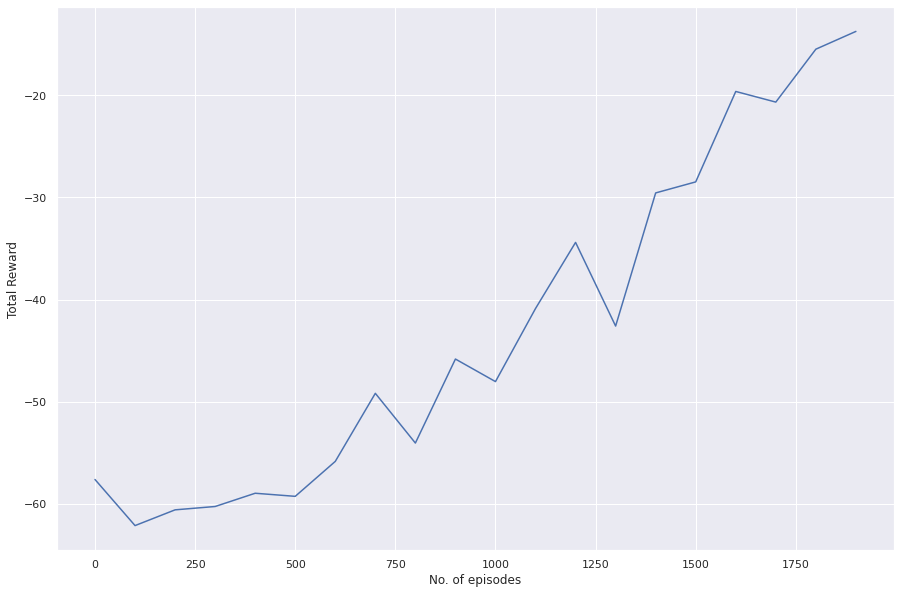

<Figure size 1080x720 with 0 Axes>

In [27]:
#let us plot the above results
import matplotlib.pyplot as plt
plt.plot(no_episodes,reward_tot)
plt.xlabel("No. of episodes")
plt.ylabel("Total Reward")
plt.figure(figsize=(15,10))


In [28]:
#now we want to plot all the trajectories to see what the density is like
def state2coord(state):
  a,b = divmod(state,10)
  return a,b

In [29]:
#we ant to write a function that will give a count of each trajectory
times_visited = np.zeros([10,10])
#we will sample 50 trajectories and keep a count of each state visited
no_steps = []
Tot_steps = 0
for t in range(50):
  state = env.reset()
  times_visited[3][0] += 1
  no_steps_this_loop = 0
  is_done = False
  while no_steps_this_loop<=100:
    action = sample_action(state)
    new_state, reward, is_done, _ = env.step(action)
    state = new_state
    a,b = divmod(state,10)
    times_visited[a][b] += 1
    no_steps_this_loop +=1
    Tot_steps += 1
  no_steps.append(no_steps_this_loop)

In [30]:
av_steps = Tot_steps/50
print(av_steps)

101.0


In [31]:
times_visited

array([[ 24.,  32.,  19.,  25.,  34.,  42.,  48.,  31.,  18.,  16.],
       [ 46.,  39.,  25.,  27.,  37.,  35.,  37.,  33.,  10.,   7.],
       [ 49.,  46.,  33.,  35.,  49.,  42.,  45.,  42.,  24.,   8.],
       [115.,  80.,  53.,  44.,  54.,  43.,  42.,  28.,  28.,  19.],
       [ 74.,  61.,  51.,  41.,  49.,  62.,  52.,  56.,  61.,  47.],
       [ 60.,  49.,  51.,  39.,  52.,  73.,  80.,  95.,  71.,  61.],
       [ 47.,  30.,  38.,  45.,  63., 108., 138., 141.,  76.,  60.],
       [ 30.,  21.,  35.,  46.,  54., 106., 149., 145.,  93.,  72.],
       [ 17.,  27.,  34.,  44.,  52.,  78., 107.,  95.,  70.,  72.],
       [ 13.,  22.,  28.,  39.,  38.,  45.,  44.,  53.,  38.,  38.]])

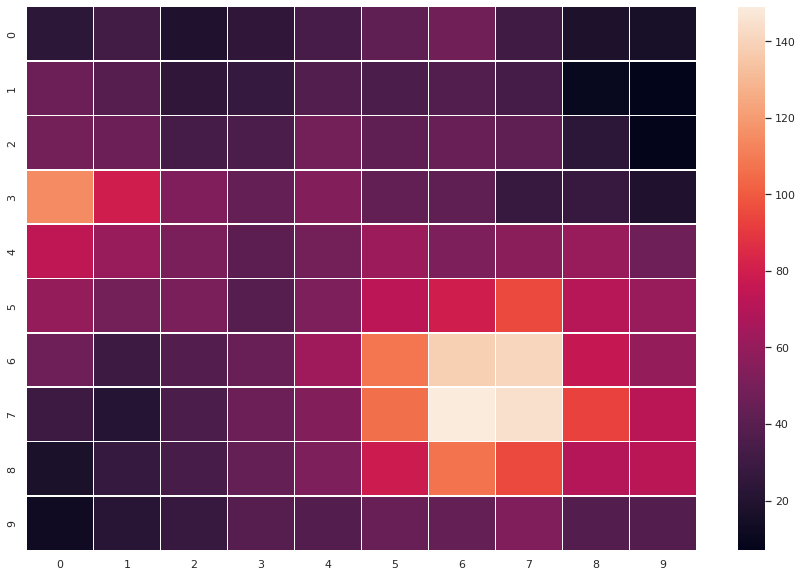

In [32]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(times_visited,linewidth = 0.5)

In [33]:
#now we want to change the learning rate and retrain the model to make it better
alpha = 0.01



In [58]:
#let us create a plot to see how the model behaves over 150 episodes
#reward_tot = []
#no_episodes = []
#tot_episodes = 0
N = 150
for i in range(20):
  rew = 0
  for j in range(N):
    steps,rew_temp = run_episode_dont_update(q,w)
    rew += rew_temp
  rew_avg = rew/N
  reward_tot.append(rew_avg)
  no_episodes.append(tot_episodes)
  #now we will train the model for 100 episodes with updates
  for j in range(100):
    a, b = run_episode(q,w)
  tot_episodes += 100

KeyboardInterrupt: ignored

In [59]:
#we want to write a function that will give a count of each trajectory
times_visited = np.zeros([10,10])
#we will sample 50 trajectories and keep a count of each state visited
no_steps = []
Tot_steps = 0
for t in range(50):
  state = env.reset()
  times_visited[3][0] += 1
  no_steps_this_loop = 0
  is_done = False
  while no_steps_this_loop<=100:
    action = sample_action(state)
    new_state, reward, is_done, _ = env.step(action)
    state = new_state
    a,b = divmod(state,10)
    times_visited[a][b] += 1
    no_steps_this_loop +=1
    Tot_steps += 1
  no_steps.append(no_steps_this_loop)

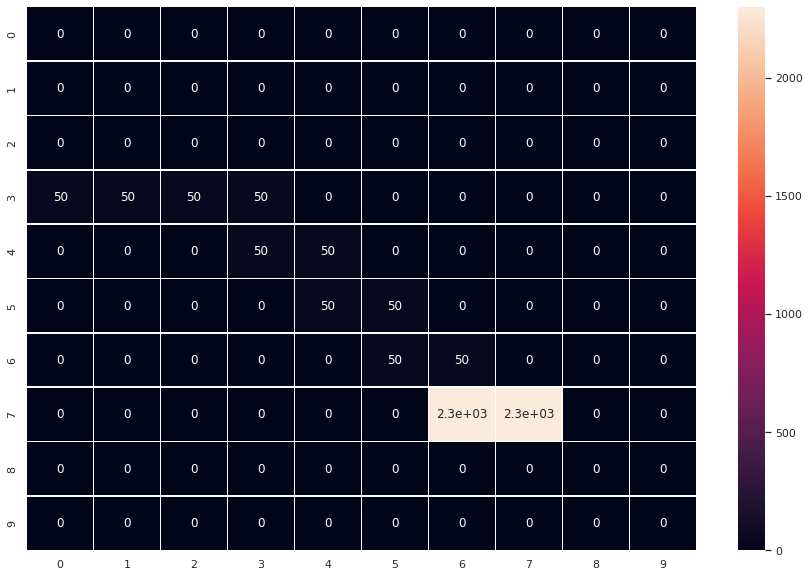

In [61]:

sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(times_visited,linewidth = 0.5,annot=True)

<Figure size 1080x720 with 0 Axes>

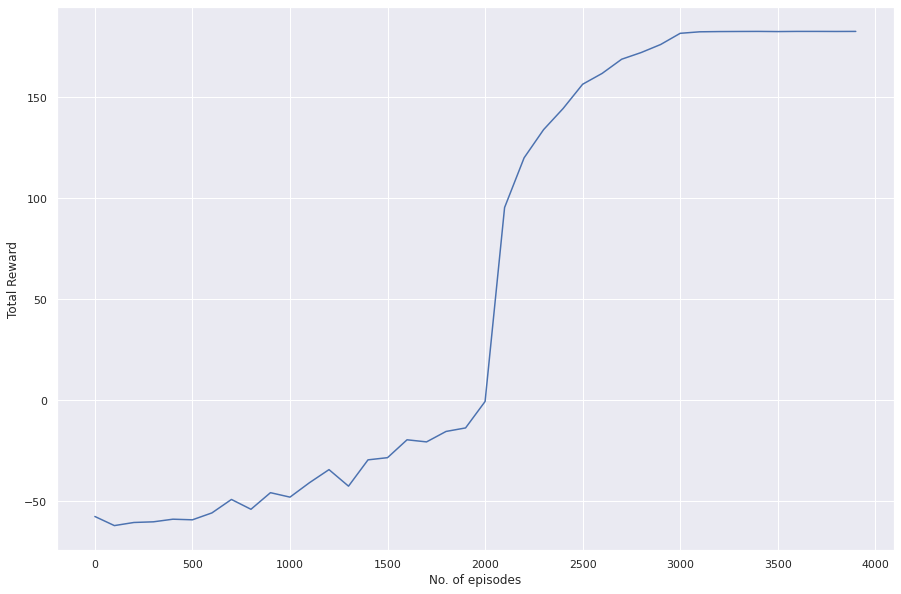

<Figure size 1080x720 with 0 Axes>

In [38]:
#let us plot the above results
import matplotlib.pyplot as plt
plt.plot(no_episodes,reward_tot)
plt.xlabel("No. of episodes")
plt.ylabel("Total Reward")
plt.figure(figsize=(15,10))


In [46]:
env.reset()

30

In [49]:
# Up:0; Right:1; Down:2; Left:3; Stay:4;
env.step(0)

(0, -0.9993523400661822, False, {'prob': 1.0})

In [63]:
#we want to write a function that will give a count of each trajectory
times_visited = np.zeros([10,10])
#we will sample 50 trajectories and keep a count of each state visited
no_steps = []
Tot_steps = 0
for t in range(50):
  state = env.reset()
  for jj in range(4):
    env.step(0)
  times_visited[0][0] += 1
  no_steps_this_loop = 0
  is_done = False
  while no_steps_this_loop<=100:
    action = sample_action(state)
    new_state, reward, is_done, _ = env.step(action)
    state = new_state
    a,b = divmod(state,10)
    times_visited[a][b] += 1
    no_steps_this_loop +=1
    Tot_steps += 1
  no_steps.append(no_steps_this_loop)

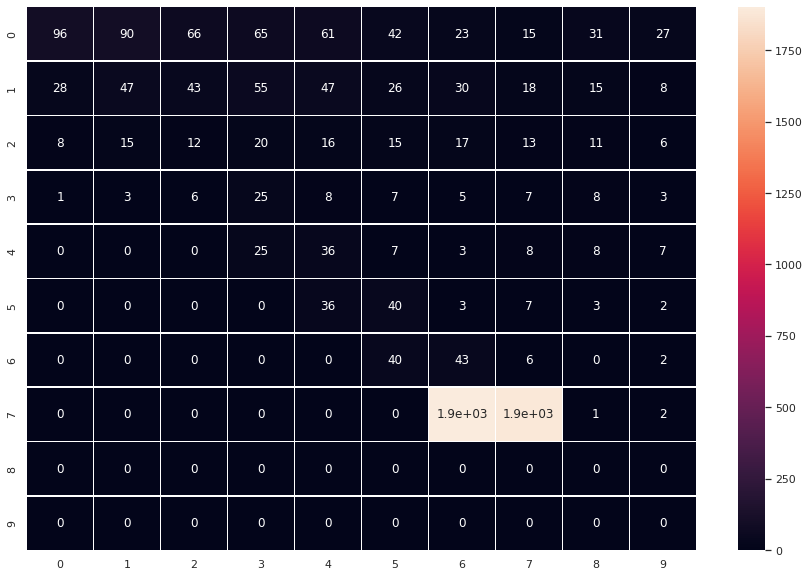

In [64]:
sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(times_visited,linewidth = 0.5,annot=True)

In [74]:
#we want to write a function that will give a count of each trajectory
times_visited = np.zeros([10,10])
#we will sample 50 trajectories and keep a count of each state visited
no_steps = []
Tot_steps = 0
for t in range(50):
  state = env.reset()
  for jj in range(10):
    env.step(2)
    env.step(1)
  times_visited[9][9] += 1
  no_steps_this_loop = 0
  is_done = False
  while no_steps_this_loop<=100:
    action = sample_action(state)
    new_state, reward, is_done, _ = env.step(action)
    state = new_state
    a,b = divmod(state,10)
    times_visited[a][b] += 1
    no_steps_this_loop +=1
    Tot_steps += 1
  no_steps.append(no_steps_this_loop)

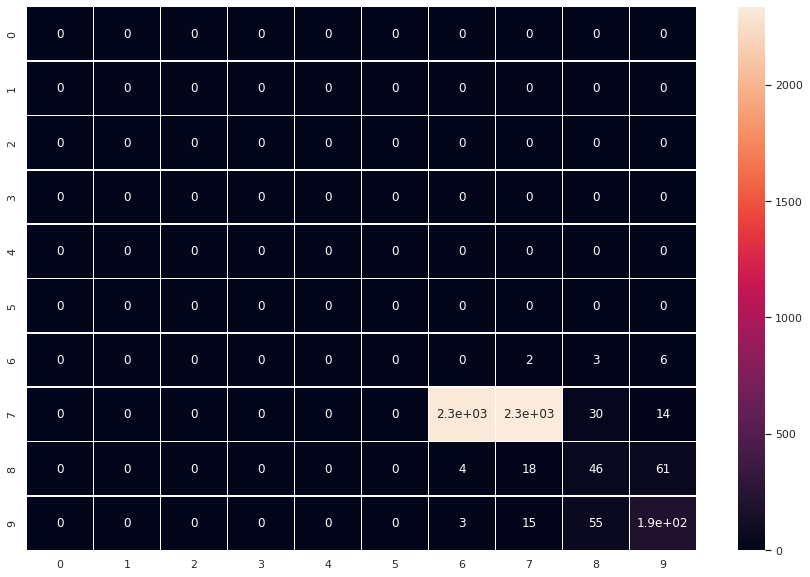

In [75]:
sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(times_visited,linewidth = 0.5,annot=True)